In [5]:
%reload_ext sql
%sql sqlite:////Users/michaellink/Desktop/__NYCDSA/_Projects/Capstone/data/citibike/sqlite/citi_bike_master.db

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import random
import seaborn as sns
from matplotlib.ticker import PercentFormatter
import numpy as np

### Here we look at the top 10000 longest trips to see if there are outliers

In [3]:
%%time
result = %sql SELECT tripduration FROM yr_2019 ORDER BY tripduration DESC;

 * sqlite:////Users/michaellink/Desktop/__NYCDSA/_Projects/Capstone/data/citibike/sqlite/citi_bike.db
Done.
CPU times: user 19.6 s, sys: 14.6 s, total: 34.1 s
Wall time: 56.9 s


In [4]:
df_top_10000_longest_trips = result.DataFrame()
df_top_10000_longest_trips['tripduration_hrs'] = df_top_10000_longest_trips['tripduration'] / (60*60)
df_top_10000_longest_trips['tripduration_days'] = df_top_10000_longest_trips['tripduration'] / (60*60*24)
df_top_10000_longest_trips[['tripduration', 'tripduration_hrs', 'tripduration_days']].head()

,tripduration,tripduration_hrs,tripduration_days
0,998775,277.437500,11.559896
1,989122,274.756111,11.448171
2,983681,273.244722,11.385197
3,982217,272.838056,11.368252
4,980590,272.386111,11.349421


In [5]:
df_top_10000_longest_trips[['tripduration', 'tripduration_hrs', 'tripduration_days']].tail()

,tripduration,tripduration_hrs,tripduration_days
20956639,0,0.0,0.0
20956640,0,0.0,0.0
20956641,0,0.0,0.0
20956642,0,0.0,0.0
20956643,0,0.0,0.0


In [6]:
df_top_10000_longest_trips.describe()

,tripduration,tripduration_hrs,tripduration_days
count,2.095664e+07,2.095664e+07,2.095664e+07
mean,1.680634e+02,4.668427e-02,1.945178e-03
std,2.523527e+03,7.009797e-01,2.920749e-02
min,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.100000e+01,8.611111e-03,3.587963e-04
50%,6.400000e+01,1.777778e-02,7.407407e-04
75%,9.700000e+01,2.694444e-02,1.122685e-03
max,9.987750e+05,2.774375e+02,1.155990e+01


In [10]:
df_top_10000_longest_trips[df_top_10000_longest_trips['tripduration']==0].shape

(172637, 3)

In [13]:
result_index = df_top_10000_longest_trips['tripduration_hrs'].sub(1).abs().idxmin()
df_top_10000_longest_trips.iloc[[result_index]][['tripduration', 'tripduration_hrs', 'tripduration_days']]

,tripduration,tripduration_hrs,tripduration_days
20063,3600,1.0,0.041667


In [14]:
num_observations = df_top_10000_longest_trips.shape[0]

In [15]:
print(f'The total number of rows in the 2019 table is {num_observations}.\nWhile the total number of tripdurations above 60 minutes is {result_index}.')
print(f'\nThe trips above 1 hour represent {round(100*(result_index/num_observations),2)} percent of the total dataset.')

The total number of rows in the 2019 table is 20956644.
While the total number of tripdurations above 60 minutes is 20063.

The trips above 1 hour represent 0.1 percent of the total dataset.


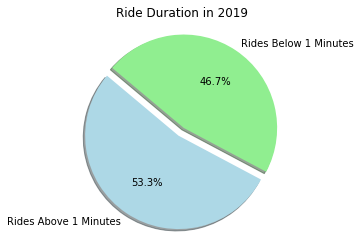

In [29]:
minutes = 1
num_above_minute = df_top_10000_longest_trips[df_top_10000_longest_trips['tripduration']>=60*minutes].shape[0]
num_below_minute = num_observations - num_above_minute

d = {f'Category': [f'Rides Above {minutes} Minutes', f'Rides Below {minutes} Minutes'], 'Number of Rides': [ num_above_minute, num_below_minute]}
df = pd.DataFrame(data=d)

labels = [f'Rides Above {minutes} Minutes', f'Rides Below {minutes} Minutes']
sizes = df['Number of Rides']
colors = ['lightblue', 'lightgreen']
explode = (0.1, 0)

plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140, )
plt.title('Ride Duration in 2019')
plt.axis('equal')
plt.show()

#### Conclusions
- The top 100 longest trips range from 11 days to 1 day
- Trips above 1 hour are pretty rare (0.1% of 2019 data) 
- If our machine learning models are problematic we could clean data above 1 hr

### San Fran vs. NYC

In [33]:
%%time
result = %sql SELECT usertype, count(*) AS count FROM cb GROUP BY usertype;

 * sqlite:////Users/michaellink/Desktop/__NYCDSA/_Projects/Capstone/data/citibike/sqlite/citi_bike.db
Done.
CPU times: user 46.1 s, sys: 20.4 s, total: 1min 6s
Wall time: 1min 53s


In [38]:
df_usertype = result.DataFrame()
df_usertype

,usertype,count
0,,52277
1,Customer,12201131
2,Subscriber,86772828


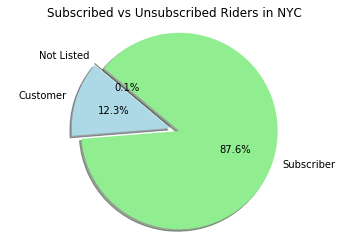

In [52]:
labels = ['Not Listed', 'Customer', 'Subscriber']
sizes = df_usertype['count']
colors = ['lightyellow', 'lightblue', 'lightgreen']
explode = (0.1, 0.1, 0)

plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140, )
plt.title('Subscribed vs Unsubscribed Riders in NYC')
plt.axis('equal')
plt.show()

In [53]:
%%time
result_time = %sql SELECT usertype, AVG(tripduration)/60 AS 'Average Duration' FROM yr_2019 GROUP BY usertype;

 * sqlite:////Users/michaellink/Desktop/__NYCDSA/_Projects/Capstone/data/citibike/sqlite/citi_bike.db
Done.
CPU times: user 9.83 s, sys: 13.4 s, total: 23.2 s
Wall time: 46.4 s


In [57]:
df_avg_trip = result_time.DataFrame()
df_avg_trip.rename(columns={'Average Duration':'Average Duration (min)'}, inplace=True)
df_avg_trip

,usertype,Average Duration (min)
0,Customer,6.699874
1,Subscriber,2.171071


### Most Popular Start Stations... OF ALL TIME

In [12]:
%%time
result = %sql SELECT start_station_name AS Station, count(*) AS Count FROM cb GROUP BY start_station_name;

   sqlite:////Users/michaellink/Desktop/__NYCDSA/_Projects/Capstone/data/citibike/sqlite/citi_bike.db
 * sqlite:////Users/michaellink/Desktop/__NYCDSA/_Projects/Capstone/data/citibike/sqlite/citi_bike_master.db
Done.
CPU times: user 1min 9s, sys: 20.9 s, total: 1min 30s
Wall time: 2min 24s


In [13]:
df_station_rides = result.DataFrame()

In [14]:
# df_station_rides.sort_values(by=['Count'], ascending=False, inplace=True)
# df_station_rides.head(5)

In [15]:
num_observations = df_station_rides['Count'].sum()

In [16]:
df_station_rides['Percent of Total Rides'] = round(100 * (df_station_rides['Count'] / num_observations), 2)
df_station_rides.rename(columns={'Count':'Number of Rides'}, inplace=True)
df_station_rides.head(5)

,Station,Number of Rides,Percent of Total Rides
0,1 Ave & E 110 St,30560,0.03
1,1 Ave & E 15 St,154640,0.16
2,1 Ave & E 16 St,260057,0.26
3,1 Ave & E 16 St [temporarily removed],4434,0.00
4,1 Ave & E 18 St,279710,0.28


In [17]:
df_station_rides.to_csv('Number_of_Rides_Starting_From_Each_Station.csv', index=False)

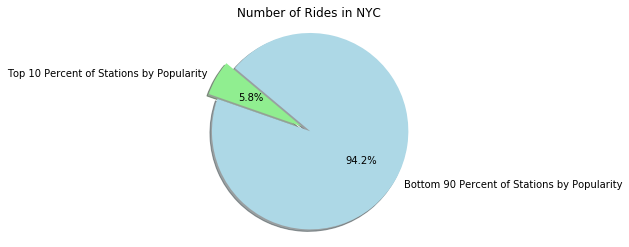

In [18]:
percent=10
n_obs_top_percent = round(df_station_rides.shape[0] * (percent/100))
rides_from_top_percent = df_station_rides[0:n_obs_top_percent+1]['Number of Rides'].sum()
rides_from_bottom_percent = df_station_rides[n_obs_top_percent+1:]['Number of Rides'].sum()
rides_from_bottom_percent

d = {'Percent of Stations': [str(percent), str(100-percent)], 'Number of Rides': [rides_from_top_percent, rides_from_bottom_percent]}
df = pd.DataFrame(data=d)

labels = [f'Top {percent} Percent of Stations by Popularity', f'Bottom {100-percent} Percent of Stations by Popularity']
sizes = df['Number of Rides']
colors = ['lightgreen', 'lightblue']
explode = (0.1, 0)

plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140, )
plt.title('Number of Rides in NYC')
plt.axis('equal')
plt.show()

In [19]:
df_station_rides.head()

,Station,Number of Rides,Percent of Total Rides
0,1 Ave & E 110 St,30560,0.03
1,1 Ave & E 15 St,154640,0.16
2,1 Ave & E 16 St,260057,0.26
3,1 Ave & E 16 St [temporarily removed],4434,0.00
4,1 Ave & E 18 St,279710,0.28


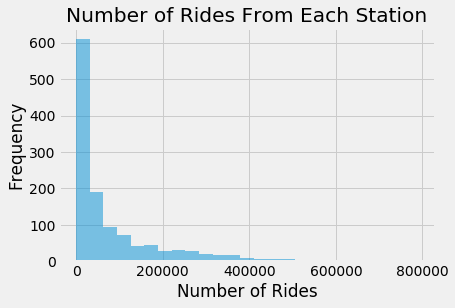

In [20]:
x = df_station_rides['Number of Rides'].values.flatten()
# y = df_station_rides[df_station_rides['User Type']=='Subscriber'][['Age']].values.flatten()

plt.style.use('fivethirtyeight')

# plt.hist(y, bins=25, alpha=0.5, label='Subscriber')
plt.hist(x, bins=25, alpha=0.5)#, label='Customer')

# plt.legend(loc='upper right')
plt.title('Number of Rides From Each Station')
plt.xlabel('Number of Rides')
plt.ylabel('Frequency')
plt.show()

### Most Popular End Stations... OF ALL TIME

In [6]:
%%time
result = %sql SELECT end_station_name AS End_Station, count(*) AS Count FROM cb GROUP BY start_station_name;

   sqlite:////Users/michaellink/Desktop/__NYCDSA/_Projects/Capstone/data/citibike/sqlite/citi_bike.db
 * sqlite:////Users/michaellink/Desktop/__NYCDSA/_Projects/Capstone/data/citibike/sqlite/citi_bike_master.db
Done.
CPU times: user 1min 15s, sys: 34.5 s, total: 1min 50s
Wall time: 3min 28s


In [7]:
df_end_station_rides = result.DataFrame()

In [8]:
# df_station_rides.sort_values(by=['Count'], ascending=False, inplace=True)
# df_station_rides.head(5)

In [9]:
num_observations = df_end_station_rides['Count'].sum()
num_observations

99026236

In [10]:
df_end_station_rides['Percent of Total Rides'] = round(100 * (df_end_station_rides['Count'] / num_observations), 2)
df_end_station_rides.rename(columns={'Count':'Number of Rides'}, inplace=True)
df_end_station_rides.head(5)

,End_Station,Number of Rides,Percent of Total Rides
0,E 103 St & Lexington Ave,30560,0.03
1,E 20 St & FDR Drive,154640,0.16
2,E 51 St & 1 Ave,260057,0.26
3,Canal St & Rutgers St,4434,0.00
4,1 Ave & E 18 St,279710,0.28


In [11]:
df_end_station_rides.to_csv('Number_of_Rides_Ending_From_Each_Station.csv', index=False)

### Start Station Rides vs. End Station Rides

In [21]:


left = df_station_rides.copy()
left.set_index('Station', inplace=True)
left.rename(columns = {'Number of Rides':'Number of Start Rides'}, inplace=True)
left.drop(['Percent of Total Rides'], axis=1, inplace=True)

right = df_end_station_rides.copy()
right.set_index('End_Station', inplace=True)
right.rename(columns = {'Number of Rides':'Number of End Rides'}, inplace=True)
right.drop(['Percent of Total Rides'], axis=1, inplace=True)

In [22]:
right.head(2)

,Number of End Rides
End_Station,
E 103 St & Lexington Ave,30560
E 20 St & FDR Drive,154640


In [23]:
right.index.is_unique

False

In [24]:
right.shape

(1230, 1)

In [25]:
right.groupby('End_Station').agg({'Number of End Rides': 'sum'}).shape

(631, 1)

In [26]:
left.head(2)

,Number of Start Rides
Station,
1 Ave & E 110 St,30560
1 Ave & E 15 St,154640


In [27]:
left.index.is_unique

True

In [28]:
left.shape

(1230, 1)

In [29]:
left.groupby('Station').agg({'Number of Start Rides': 'sum'}).shape

(1230, 1)

In [30]:
left.groupby('Station').agg({'Number of Start Rides': 'sum'}).head(2)

,Number of Start Rides
Station,
1 Ave & E 110 St,30560
1 Ave & E 15 St,154640


In [31]:
right_mod = right.groupby('End_Station').agg({'Number of End Rides': 'sum'})
right_mod.head(2)

,Number of End Rides
End_Station,
1 Ave & E 15 St,193587
1 Ave & E 18 St,852737


In [32]:
df_concat = pd.concat([left, right_mod], axis=1, sort=False)
df_concat.sample(10)

,Number of Start Rides,Number of End Rides
E 65 St & 2 Ave,55241,182604.0
Jefferson St & Cypress Ave,1383,707.0
9 St & 44 Rd,17644,NaN
Broadway & W 37 St,171957,6421.0
Convent Ave & W 135 St,208,NaN
Broadway & W 36 St,203669,75073.0
Liberty St & Broadway,252536,274574.0
Jay St & York St,75484,NaN
Underhill Ave & Lincoln Pl,29297,NaN
5 St & 6 Ave,22145,NaN


In [33]:
df_concat['Start_Ratio'] = df_concat['Number of Start Rides'] / df_concat['Number of End Rides']
df_concat.head(2)

,Number of Start Rides,Number of End Rides,Start_Ratio
1 Ave & E 110 St,30560,NaN,NaN
1 Ave & E 15 St,154640,193587.0,0.798814


In [34]:
df_concat.isna().sum()

Number of Start Rides      0
Number of End Rides      599
Start_Ratio              599
dtype: int64

In [35]:
df_concat.describe()

,Number of Start Rides,Number of End Rides,Start_Ratio
count,1230.000000,6.310000e+02,631.000000
mean,80509.134959,1.569354e+05,180.968995
std,113572.824299,2.348665e+05,3075.559980
min,1.000000,1.000000e+00,0.011599
25%,6936.000000,9.272000e+03,0.552529
50%,32261.000000,4.729200e+04,1.000000
75%,108673.500000,1.940585e+05,2.198954
max,789357.000000,1.367115e+06,72458.000000


In [36]:
df_concat.head(2)

,Number of Start Rides,Number of End Rides,Start_Ratio
1 Ave & E 110 St,30560,NaN,NaN
1 Ave & E 15 St,154640,193587.0,0.798814


In [37]:
df_concat.sort_values(by=['Start_Ratio'], inplace=True)

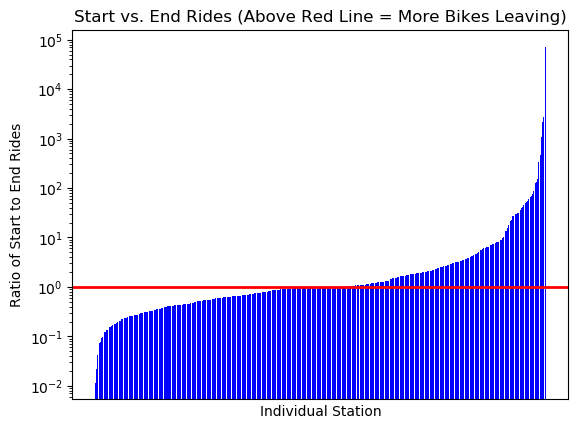

In [46]:
plt.style.use('default')
plt.bar(df_concat.index.to_list(), df_concat['Start_Ratio'], color='blue')
plt.xlabel("Individual Station")
plt.ylabel("Ratio of Start to End Rides")
plt.title("Start vs. End Rides (Above Red Line = More Bikes Leaving)")
plt.yscale('log')
plt.xticks([])
plt.axhline(y=1, linewidth=2, color='r')
plt.show()

# plt.xticks(x_pos, x)

plt.show()

In [39]:
df_concat.loc[df_concat['Start_Ratio'] >= 1, 'Station_Type'] = 'Net Bikes Leaving'
df_concat.loc[df_concat['Start_Ratio'] < 1, 'Station_Type'] = 'Net Bikes Arriving'

In [40]:
df_concat.head(2)

,Number of Start Rides,Number of End Rides,Start_Ratio,Station_Type
NYCBS Depot - SSP,1718,148122.0,0.011599,Net Bikes Arriving
Center Blvd & Borden Ave,1811,109268.0,0.016574,Net Bikes Arriving


In [41]:
pie_df_concat = df_concat.groupby('Station_Type').size().reset_index().rename(columns={0:'Count'})
pie_df_concat.head(2)

,Station_Type,Count
0,Net Bikes Arriving,289
1,Net Bikes Leaving,342


In [44]:
### Defining Color Palette 
colors = ["#FF9AA2", "#FFB7B2","#FFDAC1",'#E2F0CB','#B5EAD7','#C7CEEA']

keys = ["red", "salmon","tan",'light_green','aqua_green','purple']
values = ["#FF9AA2", "#FFB7B2","#FFDAC1",'#E2F0CB','#B5EAD7','#C7CEEA']
color_dct = dict(zip(keys, values))

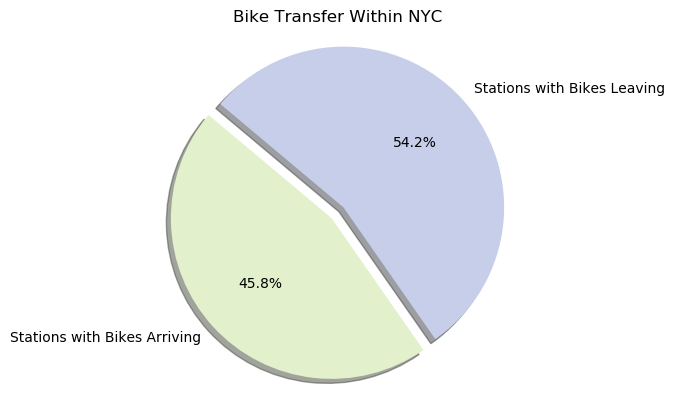

In [47]:
labels = ['Stations with Bikes Arriving', 'Stations with Bikes Leaving']
sizes = pie_df_concat['Count']
colors = [color_dct['light_green'], color_dct['purple']]
explode = (0.1, 0)

plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140, )
plt.title('Bike Transfer Within NYC')
plt.axis('equal')
plt.show()

In [43]:
df_concat['Start_Ratio'].describe()

count      631.000000
mean       180.968995
std       3075.559980
min          0.011599
25%          0.552529
50%          1.000000
75%          2.198954
max      72458.000000
Name: Start_Ratio, dtype: float64

### Rider Age

In [49]:
%%time
%sql sqlite:////Users/michaellink/Desktop/__NYCDSA/_Projects/Capstone/data/citibike/sqlite/citi_bike_yr.db
result = %sql SELECT age AS 'Age' FROM yr_2019

   sqlite:////Users/michaellink/Desktop/__NYCDSA/_Projects/Capstone/data/citibike/sqlite/citi_bike.db
   sqlite:////Users/michaellink/Desktop/__NYCDSA/_Projects/Capstone/data/citibike/sqlite/citi_bike_master.db
   sqlite:////Users/michaellink/Desktop/__NYCDSA/_Projects/Capstone/data/citibike/sqlite/citi_bike_year.db
 * sqlite:////Users/michaellink/Desktop/__NYCDSA/_Projects/Capstone/data/citibike/sqlite/citi_bike_yr.db
Done.
CPU times: user 14 s, sys: 11.2 s, total: 25.2 s
Wall time: 43.4 s


In [50]:
%%time
df_age = result.DataFrame()

CPU times: user 9.22 s, sys: 1.41 s, total: 10.6 s
Wall time: 10.8 s


In [51]:
df_age.head()

,Age
0,48
1,55
2,32
3,29
4,40


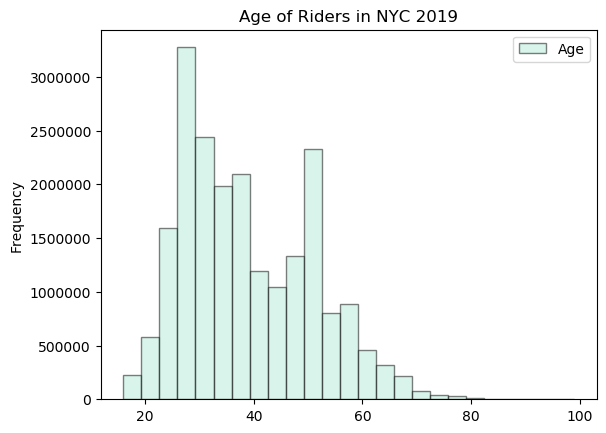

In [52]:
df_age[df_age['Age']<100].plot.hist(bins = 25, title='Age of Riders in NYC 2019', 
                                ec='black', alpha=0.5, color=color_dct['aqua_green'])

In [54]:
%%time
# %sql SELECT age AS 'Age' FROM yr_2019
%sql sqlite:////Users/michaellink/Desktop/__NYCDSA/_Projects/Capstone/data/citibike/sqlite/citi_bike_master.db
result_age_cust = %sql SELECT usertype AS 'User Type', age AS 'Age' FROM cb;

   sqlite:////Users/michaellink/Desktop/__NYCDSA/_Projects/Capstone/data/citibike/sqlite/citi_bike.db
 * sqlite:////Users/michaellink/Desktop/__NYCDSA/_Projects/Capstone/data/citibike/sqlite/citi_bike_master.db
   sqlite:////Users/michaellink/Desktop/__NYCDSA/_Projects/Capstone/data/citibike/sqlite/citi_bike_year.db
   sqlite:////Users/michaellink/Desktop/__NYCDSA/_Projects/Capstone/data/citibike/sqlite/citi_bike_yr.db
Done.
CPU times: user 1min 38s, sys: 49.8 s, total: 2min 28s
Wall time: 3min 31s


In [55]:
%%time
df_age_cust = result_age_cust.DataFrame()
df_age_cust = df_age_cust[df_age_cust['Age']<100]

CPU times: user 1min 19s, sys: 2min 53s, total: 4min 12s
Wall time: 6min 35s


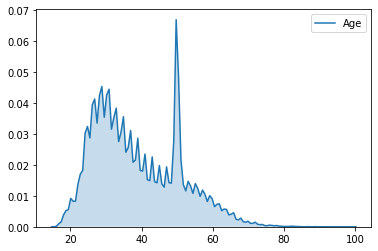

In [106]:
# library & dataset
import seaborn as sns
# df = sns.load_dataset('iris')

# density plot with shade
sns.kdeplot(df_age_cust['Age'], shade=True)
#sns.plt.show()

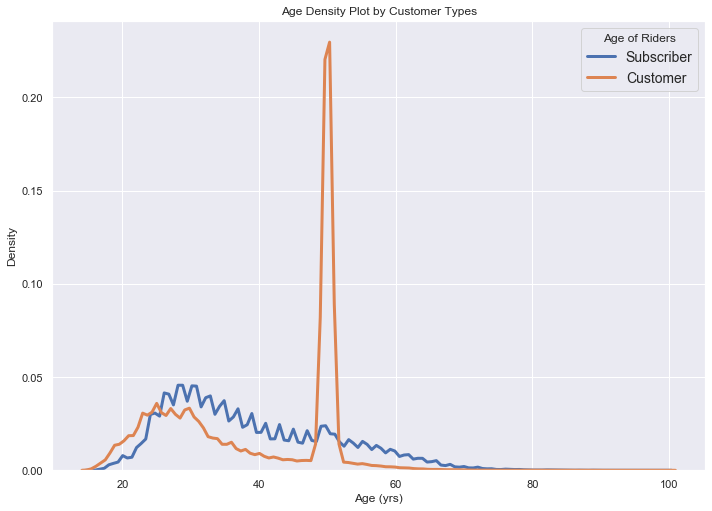

In [111]:
# List of five airlines to plot
sns.set(rc={'figure.figsize':(11.7,8.27)})
airlines = ['Subscriber', 'Customer']

# Iterate through the five airlines
for airline in airlines:
    # Subset to the airline
    subset = df_age_cust[df_age_cust['User Type'] == airline]
    
    # Draw the density plot
    sns.distplot(subset['Age'], hist = False, kde = True,
                 kde_kws = {'linewidth': 3},
                 label = airline)
    
# Plot formatting
# plt.figure(figsize=(20,10))
plt.legend(prop={'size': 14}, title = 'Age of Riders')
plt.title('Age Density Plot by Customer Types')
plt.xlabel('Age (yrs)')
plt.ylabel('Density')
plt.show()

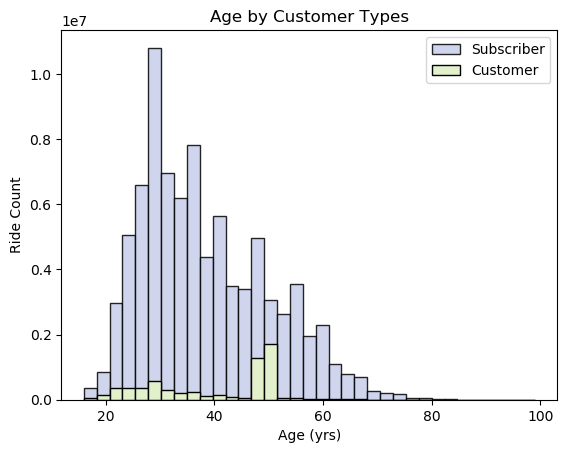

In [59]:
from matplotlib import pyplot

x = df_age_cust[df_age_cust['User Type']=='Customer'][['Age']].values.flatten()
y = df_age_cust[df_age_cust['User Type']=='Subscriber'][['Age']].values.flatten()

plt.style.use('default')

plt.hist(y, bins=35, alpha=0.85, label='Subscriber', color=color_dct['purple'], ec='black')
plt.hist(x, bins=35, label='Customer', color=color_dct['light_green'], ec='black') #, alpha=0.5

plt.legend(loc='upper right')
plt.title('Age by Customer Types')
plt.xlabel('Age (yrs)')
plt.ylabel('Ride Count')
plt.show()

In [122]:
df_age_cust[df_age_cust['User Type']=='Customer'][['Age']].head().values.flatten()

array([30, 50, 50, 50, 50])

### Most Popular Trips (From A to B)

In [25]:
df_top_10000_longest_trips.columns

Index(['tripduration', 'starttime', 'stoptime', 'start_station_id',
       'start_station_name', 'start_station_latitude',
       'start_station_longitude', 'end_station_id', 'end_station_name',
       'end_station_latitude', 'end_station_longitude', 'bikeid', 'usertype',
       'birth_year', 'gender', 'counter', 'year', 'age', 'tripduration_hrs',
       'tripduration_days'],
      dtype='object')

In [3]:
%%time
result = %sql SELECT start_station_name, end_station_name, COUNT(*) AS Count FROM yr_2019 GROUP BY start_station_name, end_station_name ORDER BY Count DESC;

 * sqlite:////Users/michaellink/Desktop/__NYCDSA/_Projects/Capstone/data/citibike/sqlite/citi_bike.db
Done.
CPU times: user 29.4 s, sys: 17.3 s, total: 46.8 s
Wall time: 1min 10s


In [7]:
df_2019_unique_trips=result.DataFrame()
df_2019_unique_trips.head()

,start_station_name,end_station_name,Count
0,Hamilton Park,Grove St PATH,8778
1,E 7 St & Avenue A,Cooper Square & Astor Pl,8426
2,Central Park S & 6 Ave,Central Park S & 6 Ave,6778
3,Central Park S & 6 Ave,5 Ave & E 88 St,6092
4,Grove St PATH,Hamilton Park,6050


In [6]:
%%time
result_cb = %sql SELECT start_station_name, end_station_name, COUNT(*) AS Count FROM cb GROUP BY start_station_name, end_station_name ORDER BY Count DESC;

 * sqlite:////Users/michaellink/Desktop/__NYCDSA/_Projects/Capstone/data/citibike/sqlite/citi_bike.db
Done.
CPU times: user 2min 25s, sys: 39 s, total: 3min 4s
Wall time: 5min 11s


In [11]:
df_total_unique_trips = result_cb.DataFrame()
df_total_unique_trips['Percent of Total Trips'] = 100 * (df_total_unique_trips.Count / df_total_unique_trips.Count.sum())

In [15]:
df_total_unique_trips.loc[df_total_unique_trips['start_station_name'] == df_total_unique_trips['end_station_name'], 'Same_Station'] = 'Same Return Station'
df_total_unique_trips.loc[df_total_unique_trips['start_station_name'] != df_total_unique_trips['end_station_name'], 'Same_Station'] = 'Different Return Station'

In [78]:
df_total_unique_trips.to_csv('Number_of_Unique_Trips.csv', index=False)

In [63]:
df_total_unique_trips.tail(1000).sample(10)

,start_station_name,end_station_name,Count,Percent of Total Trips,Same_Station
636780,Wyckoff St & Nevins St,University Pl & E 8 St,1,0.000001,Different Return Station
636098,Withers St & Kingsland Ave,Central Ave & Woodbine St,1,0.000001,Different Return Station
636207,Wolcott St & Dwight St,Fulton St & Clermont Ave,1,0.000001,Different Return Station
636594,Wyckoff St & 3 Ave,Water - Whitehall Plaza,1,0.000001,Different Return Station
636091,Withers St & Kingsland Ave,Cadman Plaza West & Montague St,1,0.000001,Different Return Station
636027,Wilson Ave & Troutman St,Park Ave & St Edwards St,1,0.000001,Different Return Station
636370,Wyckoff Av & Jefferson St,E 33 St & 1 Ave,1,0.000001,Different Return Station
636333,Wyckoff Av & Jefferson St,31 St & Broadway,1,0.000001,Different Return Station
636339,Wyckoff Av & Jefferson St,49 Ave & 21 St,1,0.000001,Different Return Station
636442,Wyckoff Av & Stanhope St,Bergen St & Vanderbilt Ave,1,0.000001,Different Return Station


In [62]:
df_total_unique_trips = pd.read_csv('Number_of_Unique_Trips.csv')

In [69]:
df_total_unique_trips[df_total_unique_trips['Same_Station']=='Different Return Station'].shape

(635782, 5)

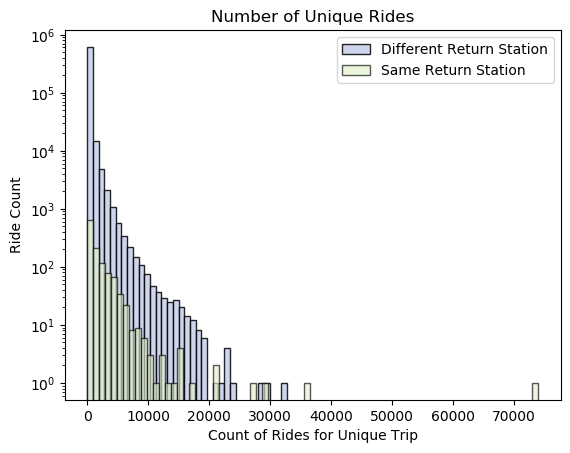

In [72]:
x = df_total_unique_trips[df_total_unique_trips['Same_Station']=='Same Return Station'][['Count']].values.flatten()
y = df_total_unique_trips[df_total_unique_trips['Same_Station']=='Different Return Station'][['Count']].values.flatten()

max_val=1000000
x=x[x<max_val]
y=y[y<max_val]


plt.style.use('default')

plt.hist(y, bins=35, alpha=0.85, label='Different Return Station', log=True, ec='black', color=color_dct['purple'])
plt.hist(x, bins=75, alpha=0.65, label='Same Return Station', log=True, ec='black', color=color_dct['light_green'])

plt.legend(loc='upper right')
plt.title('Number of Unique Rides')
plt.xlabel('Count of Rides for Unique Trip')
plt.ylabel('Ride Count')
plt.show()

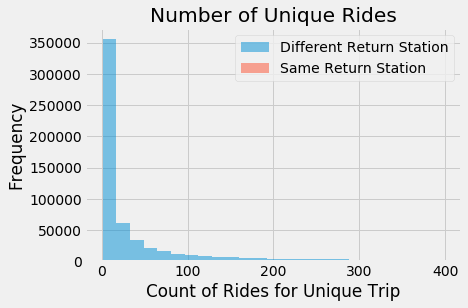

In [35]:
x = df_total_unique_trips[df_total_unique_trips['Same_Station']=='Same Return Station'][['Count']].values.flatten()
y = df_total_unique_trips[df_total_unique_trips['Same_Station']=='Different Return Station'][['Count']].values.flatten()

max_val=400
x=x[x<max_val]
y=y[y<max_val]


plt.style.use('fivethirtyeight')

plt.hist(y, bins=25, alpha=0.5, label='Different Return Station')#, log=True)
plt.hist(x, bins=25, alpha=0.5, label='Same Return Station')#, log=True)

plt.legend(loc='upper right')
plt.title('Number of Unique Rides')
plt.xlabel('Count of Rides for Unique Trip')
plt.ylabel('Frequency')
plt.show()

In [73]:
pie_df_total_unique_trips = df_total_unique_trips.groupby('Same_Station').agg({'Count': 'sum'})
pie_df_total_unique_trips

,Count
Same_Station,
Different Return Station,96755783
Same Return Station,2270453


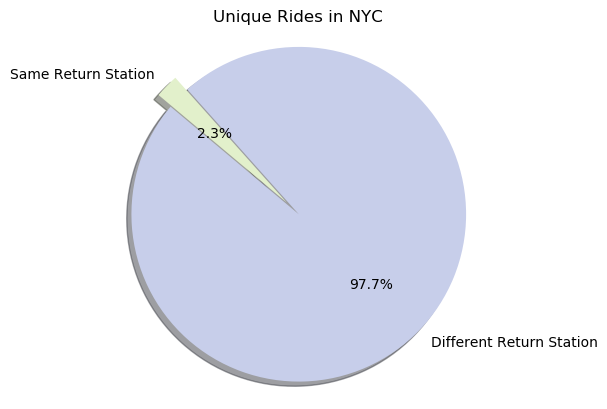

In [75]:
labels = ['Different Return Station', 'Same Return Station']
sizes = pie_df_total_unique_trips['Count']
colors = [color_dct['purple'], color_dct['light_green']]
explode = (0.1, 0)

plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140, )
plt.title('Unique Rides in NYC')
plt.axis('equal')
plt.show()

In [41]:
df_total_unique_trips.head(2)

,start_station_name,end_station_name,Count,Percent of Total Trips,Same_Station
0,Central Park S & 6 Ave,Central Park S & 6 Ave,74021,0.074749,Same Return Station
1,Grand Army Plaza & Central Park S,Grand Army Plaza & Central Park S,36280,0.036637,Same Return Station


In [44]:
df_total_unique_trips.shape[0]*0.01

637001